#### Load libraries and set random number generator seed

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pydot
from skimage import io
import numpy as np
import tensorflow_datasets as tfds
from pathlib import Path

In [2]:
np.random.seed(42)

In [3]:

from google.colab import drive
drive.mount('/content/drive')
for fname in os.listdir("/content/drive/MyDrive/Test/flowers"):
  print(fname)


Mounted at /content/drive
.DS_Store
training
test


In [4]:
num_skipped = 0
for folder_name in ("test", "training"):
    for flower in ("daisy", "dandelion", "rose", "sunflower", "tulip"):
      folder_path = os.path.join("/content/drive/MyDrive/Test/flowers/", folder_name, flower )
      for fname in os.listdir(folder_path):
          fpath = os.path.join(folder_path, fname)
          try:
              fobj = open(fpath, "rb")
              is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
          finally:
              fobj.close()

          if not is_jfif:
              num_skipped += 1
              # Delete corrupted image
              os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Test/flowers/training/",
    validation_split=0.2,
    labels='inferred',
    subset="training",
    seed=42,
    label_mode = 'categorical',
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Test/flowers/training/",
    validation_split=0.2,
    labels='inferred',
    subset="validation",
    seed=42,
    label_mode = 'categorical',
    image_size=image_size, 
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Test/flowers/test/",
   labels='inferred',
   label_mode = 'categorical',
    seed=42,
    image_size=image_size,
    batch_size=1,
)

Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


#### Code the solution

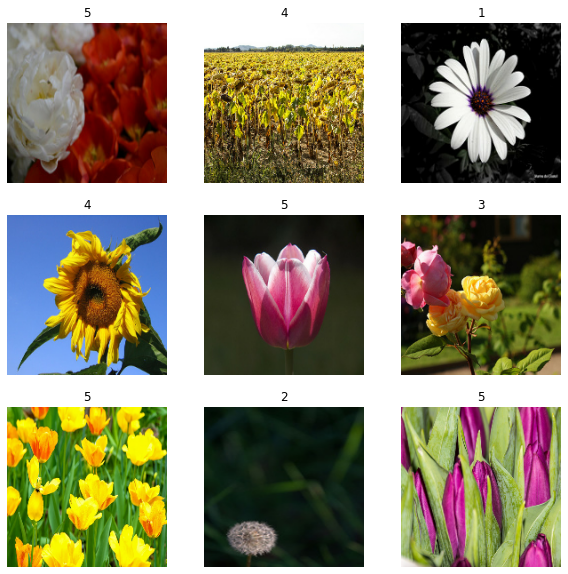

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    #print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if(labels[i][0] == 1):
          plt.title(1)
        elif(labels[i][1] == 1):
          plt.title(2)
        elif(labels[i][2] == 1):
          plt.title(3)
        elif(labels[i][3] == 1):
          plt.title(4)
        elif(labels[i][4] == 1):
          plt.title(5)

        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

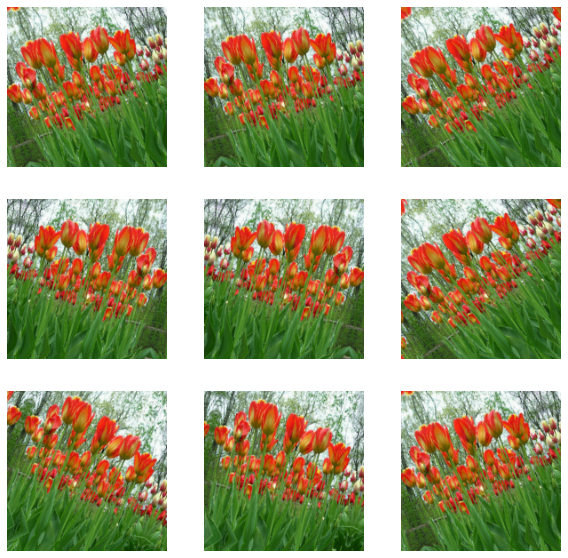

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [10]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)


Epoch 1/20
87/87 [==============================] - 39s 284ms/step - loss: 1.2447 - accuracy: 0.5436 - val_loss: 1.6797 - val_accuracy: 0.2590
Epoch 2/20
87/87 [==============================] - 23s 257ms/step - loss: 1.0245 - accuracy: 0.6253 - val_loss: 2.4553 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 23s 262ms/step - loss: 0.8999 - accuracy: 0.6691 - val_loss: 3.3453 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 24s 272ms/step - loss: 0.8644 - accuracy: 0.6817 - val_loss: 3.6288 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 23s 262ms/step - loss: 0.8001 - accuracy: 0.7074 - val_loss: 4.3524 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 23s 262ms/step - loss: 0.7321 - accuracy: 0.7327 - val_loss: 1.7333 - val_accuracy: 0.4124
Epoch 7/20
87/87 [==============================] - 23s 263ms/step - loss: 0.7143 - accuracy: 0.7400 - val_loss: 1.2429 - val_accuracy: 0.5876

In [12]:
predicted_labels = []
true_labels = []
misclassifications = []
count = 0
for x, y in test_ds:
  arr = model.predict(x)
  predicted_labels.append(arr.argmax())
  for i in range(0, len(y[0])):
    if y[0][i] == 1:
      true_labels.append(i)
      break
  if predicted_labels[-1] != true_labels[-1] and count < 3:
    count += 1
    misclassifications.append([x, predicted_labels[-1], true_labels[-1]])

  
  
conf_matrix = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy() 


In [ ]:

print(predicted_labels)
print(true_labels)
conf_matrix = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy()
conf_matrix

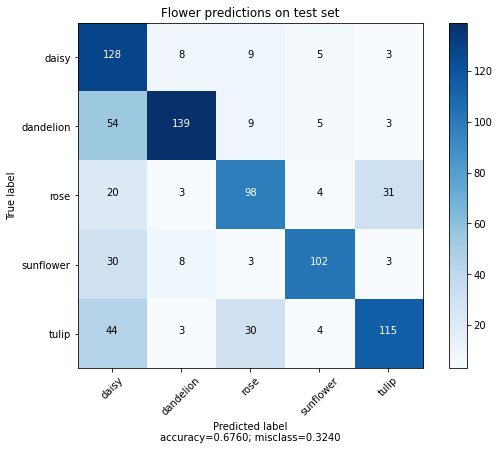

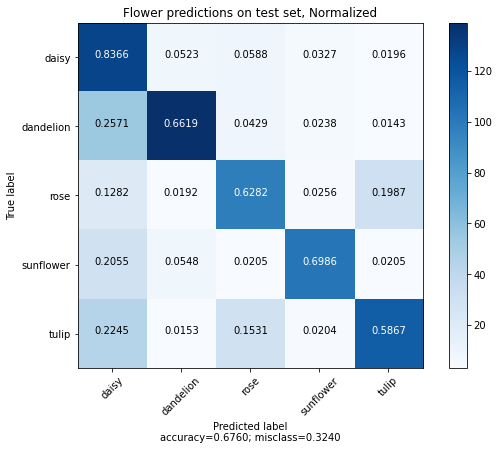

In [14]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm = conf_matrix, 
                      normalize    = False,
                      target_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"],
                      title        = "Flower predictions on test set")

plot_confusion_matrix(cm = conf_matrix, 
                      normalize    = True,
                      target_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"],
                      title        = "Flower predictions on test set, Normalized")

 

Text(0.5, 1.0, 'sunflower predicted as dandelion')

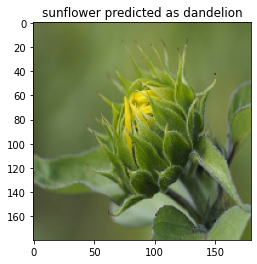

In [15]:
labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
img, predicted_label, actual_label = misclassifications[0]
plt.imshow(img[0]/255)
plt.title("{0} predicted as {1}".format(labels[actual_label], labels[predicted_label] ))

Text(0.5, 1.0, 'sunflower predicted as dandelion')

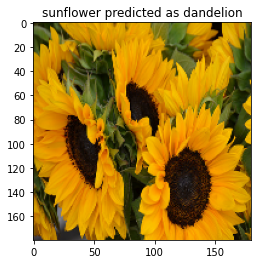

In [72]:
labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
img, predicted_label, actual_label = misclassifications[1]
plt.imshow(img[0]/255)
plt.title("{0} predicted as {1}".format(labels[actual_label], labels[predicted_label] ))

Text(0.5, 1.0, 'tulip predicted as dandelion')

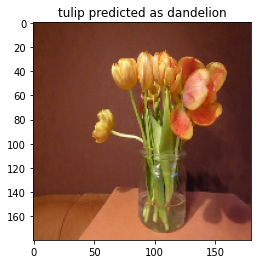

In [73]:
labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
img, predicted_label, actual_label = misclassifications[2]
plt.imshow(img[0]/255)
plt.title("{0} predicted as {1}".format(labels[actual_label], labels[predicted_label] ))